# RISE explanation applied to RMN model

The RISE implementation used here can be found at : https://github.com/eclique/RISE.

In [1]:
import numpy as np
from matplotlib import pyplot as plt

from rmn import *
from rise import RISE
from utils.img_functions import *

import os
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

c:\Users\terai\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading images and building RMN model

In [3]:
## Load then pre-process dataset
csvBV = ".\\datasets\\labels\\BV_labels.csv"
BVpath = ".\\datasets\\BV"
csvET = ".\\datasets\\labels\\ET_labels.csv"
ETpath = ".\\datasets\\ET"
imgs, df_labels = load_all(csvBV,BVpath,csvET,ETpath)

# Display predictions for a single image
def rmn_predict(img):
    predict = RMN()
    result = predict.detect_emotion_for_single_face_image(face_image=img)
    return result

# Build model
model = get_emo_model()
model = model.cuda()
for p in model.parameters():
    p.requires_grad = False
# To use multiple GPUs
model = nn.DataParallel(model)

Loaded 200 images successfully
Created dataframe for labels


## Generating RISE masks

In [4]:
explainer = RISE(model=model,input_size=(224,224),gpu_batch=100)

# Generate masks for RISE or use the saved ones.
maskspath = 'masks.npy'
generate_new = True

if generate_new or not os.path.isfile(maskspath):
    explainer.generate_masks(N=6000, s=8, p1=0.1, savepath=maskspath)
else:
    explainer.load_masks(maskspath)
    print('Masks are loaded.')

Generating filters: 100%|██████████| 6000/6000 [00:07<00:00, 851.19it/s]


## Displaying saliency maps using generated masks

In [5]:
emotions = ['angry','disgust','fear','happy','sad','surprise','neutral']
# Get class name matching given int
def get_class_name(k):
    return emotions[k]

In [6]:
# Plot image from tensor
def tensor_imshow(inp, title=None, **kwargs):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp, **kwargs)
    if title is not None:
        plt.title(title)

In [8]:
def compute_rise(img, top_k):

    # Pre-processing data
    to_tensor = transforms.ToTensor()
    normalized_np = np.array(img) / np.max(np.array(img))
    input_tensor = to_tensor(img.copy()).unsqueeze(0)

    # Generating RISE explanations
    # warning : the following code is specifically designed with RMN model in mind
    saliency = explainer(input_tensor)
    output = torch.squeeze(model(input_tensor.cuda()),0)
    proba = torch.softmax(output,0)
    p, c = torch.topk(proba, k=top_k)

    # Displaying explanations
    plt.figure(figsize=(10, 5*top_k))
    for k in range(top_k):
        # Display original image
        plt.subplot(top_k, 2, 2*k+1)
        plt.axis('off')
        tensor_imshow(input_tensor[0])
        # Display saliency map over original image
        plt.subplot(top_k, 2, 2*k+2)
        plt.axis('off')
        plt.title('RMN predicted '+get_class_name(c[k])+'\n with score '+str(p[k].item()))
        tensor_imshow(input_tensor[0])
        sal = saliency[c[k].item()].cpu()
        plt.imshow(sal, cmap='jet', alpha=0.5)
        plt.colorbar(fraction=0.046, pad=0.04)
    plt.show()

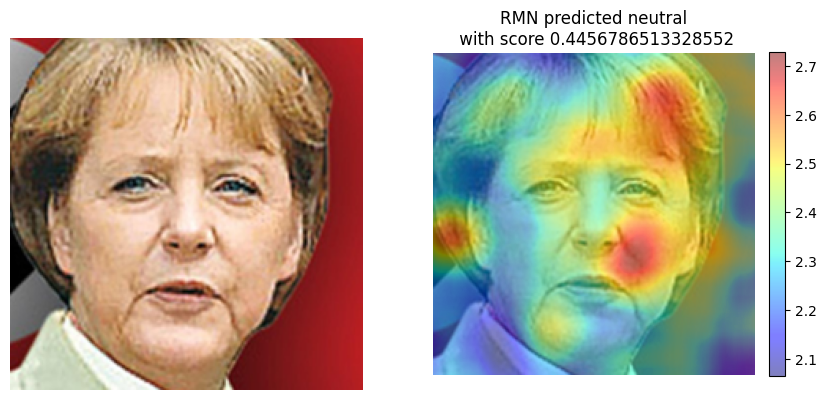

In [11]:
compute_rise(imgs[46],top_k=1)